# Exercises

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

sns.set_theme(context='notebook',style='white',font_scale=1.5,
              rc = {'axes.spines.top':False,'axes.spines.right':False})
from scipy.optimize import minimize

## Exercise 1
---
Determine the effect of stimulus sequence duration on RF estimates. To do this, repeat the above steps for different durations (5 s, 10 s, 20 s, 40 s, 80 s, 160 s, 320 s, 640 s). Compute the Pearson correlation between true and estimated RFs for each duration to quantify the accuracy of the estimator. The Pearson correlation $\mathrm{cc}$ is defined as
$$
\mathrm{cc} = \frac{\mathbf{k}_\mathrm{true}^T \hat{\mathbf{k}}}{\lVert \mathbf{k}_\mathrm{true} \rVert \lVert \hat{\mathbf{k}} \rVert}
$$
where $\lVert \cdot \rVert$ is the L2-norm (vector length).
As the response generation process is stochastic, compute the average correlation across 10 realizations for the same duration and plot the average correlation as a function of duration. How is the recording duration related to the ability to recover the true RF? 

In [2]:
#Defining

dt = .1
std_dev = 1
vf_size = (15,15)

size = vf_size # size in pixel of our receptive field
mu = (8, 8) # center of the gabor pathc
sigma = (4,4) #size of the gabor patch
angle = 45 # orientation of the gabor patch
frequency = .085 # spatial frequency of the gabor patch
phase = 0 # pahse of the gabor pathc


xx, yy = np.meshgrid(1. + np.arange(size[0]),
                         1. + np.arange(size[1]))

# Gaussian envelope
G = np.exp(- np.power(xx - mu[0], 2) / (2. * sigma[0])
            - np.power(yy - mu[1], 2) / (2. * sigma[1]))

# spatial modulation
phi = np.deg2rad(angle)
xxr = xx * np.cos(phi)
yyr = yy * np.sin(phi)
xyr = (xxr + yyr) * 2. * np.pi * 2. * frequency
Sn = np.cos(xyr + phase)

K = G * Sn
K /= np.amax(np.abs(K))

noise_variance = 1
offset = 2.
def generate_inhomogeneous_poisson_spikes(lamda, dt):

    n_bins = lamda.shape[0]
    bins = np.arange(n_bins+1)*dt

    # generate Poisson distributed numbers for all bins with the max. intensity (lamda_max)
    lamda_max = np.max(lamda)
    poisson_numbers = np.random.poisson(lamda_max, size=n_bins)

    # throw away numbers depending on the actual intensity ("thinning")
    spike_times = []
    prob = lamda / lamda_max
    for i in range(n_bins):
        
        # number of spikes to keep in this bin
        n = np.sum(np.random.rand(poisson_numbers[i]) < prob[i])
        n_s = int(round(n * dt))

        # generate random spike times in this bin
        ts = bins[i] + np.random.rand(n_s)*dt

        spike_times.extend(ts)

    return np.asarray(spike_times)
spike_rate = 5 
# flatten the matrices in to 1d array for convenience
K_flat = K.ravel()
K_flat = np.hstack((K.flat, offset))

# define functions for minimisation
def cost(k, spike_counts, S,alpha=1):
    #negative loglikelihood function to minimize
    ks = np.dot(k, S.T)
    lamda = np.exp(ks)
    return -np.dot(spike_counts, ks) + dt * np.sum(lamda)
    
    
def grad(k, spike_counts, S):
    # expression of the gradient of the negative log likelihood (note the sign is flipped accordingly)

    ks = np.dot(k, S.T)
    lamda = np.exp(ks)
    return -np.dot(S.T, spike_counts - dt*lamda)







In [3]:
#Looping over different durations
durations = [5,10,20,40,60,80,160,320,640]
PC=[]
for j in durations:
    n_bins = round(j / float(dt))
    S = std_dev * np.random.randn(n_bins,vf_size[0],vf_size[1])
    S_flat = S.reshape(S.shape[0],S.shape[1]*S.shape[2])
    S_flat = np.hstack((S_flat, np.ones((n_bins, 1))))


    # 1. linear stage
    ks = np.dot(K_flat, S_flat.T)

    # 2. nonlinear stage (for a linear model: f -> identity function)
    lamda = np.exp(ks)

    expected_rate = np.sum(lamda*dt) / j
    lamda *= (spike_rate / expected_rate)

    # generate spike times using an inhomogeneous Poisson process
    spike_times = generate_inhomogeneous_poisson_spikes(lamda, dt)

    # compute spike counts in the different time bins
    spike_counts = np.histogram(spike_times,
                                bins=np.arange(n_bins+1)*dt)[0]
    k_STA = np.inner(S_flat.T, spike_counts) / np.sum(spike_counts)
    res = minimize(fun = cost, x0 = k_STA / 10, args = (spike_counts, S_flat), method = 'Newton-CG', jac = grad)

    K_est = res.x
    
    pcorr=format(np.inner(K.ravel(), K_est[:-1]) / (np.linalg.norm(K.ravel()) * np.linalg.norm(K_est[:-1])))
    PC.append(pcorr)
    print(j, "seconds Pearson correlation = {:.3f}".format(np.inner(K.ravel(), K_est[:-1]) / (np.linalg.norm(K.ravel()) * np.linalg.norm(K_est[:-1]))))
TPC = [eval(i) for i in PC]
print("Average across 10 realizations=", np.mean(TPC))
    

    

5 seconds Pearson correlation = 0.196
10 seconds Pearson correlation = 0.105
20 seconds Pearson correlation = 0.409
40 seconds Pearson correlation = 0.582
60 seconds Pearson correlation = 0.682
80 seconds Pearson correlation = 0.766
160 seconds Pearson correlation = 0.802
320 seconds Pearson correlation = 0.973
640 seconds Pearson correlation = 0.987
Average across 10 realizations= 0.6113227070877542


In [4]:
#Averaging
Pcs=[]
duration = [50,50,50,50,50,50,50,50,50,50]
for j in duration:
    n_bins = round(j / float(dt))
    S = std_dev * np.random.randn(n_bins,vf_size[0],vf_size[1])
    S_flat = S.reshape(S.shape[0],S.shape[1]*S.shape[2])
    S_flat = np.hstack((S_flat, np.ones((n_bins, 1))))


    # 1. linear stage
    ks = np.dot(K_flat, S_flat.T)

    # 2. nonlinear stage (for a linear model: f -> identity function)
    lamda = np.exp(ks)
    lamda *= (spike_rate / expected_rate)

    # generate spike times using an inhomogeneous Poisson process
    spike_times = generate_inhomogeneous_poisson_spikes(lamda, dt)

    # compute spike counts in the different time bins
    spike_counts = np.histogram(spike_times,
                                bins=np.arange(n_bins+1)*dt)[0]
    k_STA = np.inner(S_flat.T, spike_counts) / np.sum(spike_counts)
    res = minimize(fun = cost, x0 = k_STA / 10, args = (spike_counts, S_flat), method = 'Newton-CG', jac = grad)

    K_est = res.x
    pc=format(np.inner(K.ravel(), K_est[:-1]) / (np.linalg.norm(K.ravel()) * np.linalg.norm(K_est[:-1])))
    Pcs.append(pc)

    print( "Pearson correlation =",pc)
TPcs = [eval(i) for i in Pcs]
print("Average across 10 realizations=", np.mean(TPcs))


Pearson correlation = 0.6186414465860076
Pearson correlation = 0.5350805503969776
Pearson correlation = 0.5795263133031738
Pearson correlation = 0.64102134347663
Pearson correlation = 0.5680265824817429
Pearson correlation = 0.6007681349901605
Pearson correlation = 0.4762349078253213
Pearson correlation = 0.5708982863304408
Pearson correlation = 0.5043603148424574
Pearson correlation = 0.5386444887588996
Average across 10 realizations= 0.5633202368991811


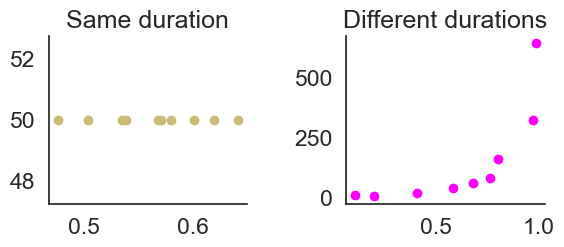

In [5]:
#Plotting

fig=plt.figure()
plt.subplots_adjust(wspace=0.5)
sub_plot1 = fig.add_subplot(2,2,1)
sub_plot1.title.set_text('Same duration')
sub_plot1.plot(TPcs,duration,'o',color='y')
sub_plot2 = fig.add_subplot(2,2,2)
sub_plot2.title.set_text('Different durations')
sub_plot2.plot(TPC,durations,'o',color= 'magenta')



 <font color='blue'>We can see that the relation between duration and correlation is analogous. For longer durations we get higher Pearson correlation.</font> 


## Exercise 2
---
Determine the effect of response noise ($\sigma^2$) on RF estimates. Try different value for the noise variance in the simulations, e.g., 0, 2, 4, 6, 8, and 10 for a duration of 100 s. As in the previous excercise, repeatedly estimate RF parameters for each condition (10 times) but this time also plot the standard deviation of the correlations across the different runs for each condition.

In [6]:
noise=[0,2,4,6,8,10]
dur=[100,100,100,100,100,100,100,100,100,100]
fpcs=[]
std=[]

for n in noise:
    lamda=np.exp(ks+n)
    ipcs=[]
    for j in dur:
        n_bins = round(j / float(dt))
        S = std_dev * np.random.randn(n_bins,vf_size[0],vf_size[1])
        S_flat = S.reshape(S.shape[0],S.shape[1]*S.shape[2])
        S_flat = np.hstack((S_flat, np.ones((n_bins, 1))))


        # 1. linear stage
        ks = np.dot(K_flat, S_flat.T)
    

        expected_rate = np.sum(lamda*dt) / j
        lamda *= (spike_rate / expected_rate)

        # generate spike times using an inhomogeneous Poisson process
        spike_times = generate_inhomogeneous_poisson_spikes(lamda, dt)

        # compute spike counts in the different time bins
        spike_counts = np.histogram(spike_times,
                                    bins=np.arange(n_bins+1)*dt)[0]
        k_STA = np.inner(S_flat.T, spike_counts) / np.sum(spike_counts)
        res = minimize(fun = cost, x0 = k_STA / 10, args = (spike_counts, S_flat), method = 'Newton-CG', jac = grad)

        K_est = res.x
        pc=np.inner(K.ravel(), K_est[:-1]) / (np.linalg.norm(K.ravel()) * np.linalg.norm(K_est[:-1]))
        ipcs.append(pc)
    std.append(np.std(ipcs))
    fpcs.append(ipcs)     

    




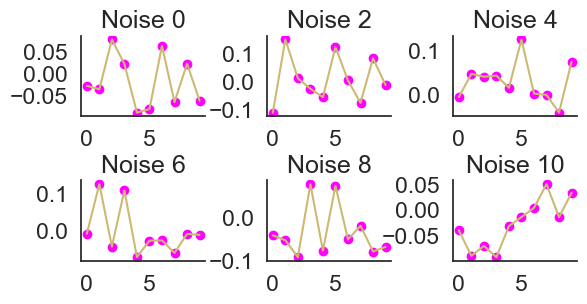

In [7]:
#Plotting
fig=plt.figure()
plt.subplots_adjust(wspace=0.5,hspace=0.8)
sub_plot1 = fig.add_subplot(3,3,1)
sub_plot1.title.set_text('Noise 0')
sub_plot1.plot(fpcs[0],'o',color='magenta')
sub_plot1.plot(fpcs[0],'-',color='y')

sub_plot2 = fig.add_subplot(3,3,2)
sub_plot2.title.set_text('Noise 2')
sub_plot2.plot(fpcs[1],'o',color='magenta')
sub_plot2.plot(fpcs[1],'-',color='y')

sub_plot2 = fig.add_subplot(3,3,3)
sub_plot2.title.set_text('Noise 4')
sub_plot2.plot(fpcs[2],'o',color='magenta')
sub_plot2.plot(fpcs[2],'-',color='y')

sub_plot2 = fig.add_subplot(3,3,4)
sub_plot2.title.set_text('Noise 6')
sub_plot2.plot(fpcs[3],'o',color='magenta')
sub_plot2.plot(fpcs[3],'-',color='y')

sub_plot2 = fig.add_subplot(3,3,5)
sub_plot2.title.set_text('Noise 8')
sub_plot2.plot(fpcs[4],'o',color='magenta')
sub_plot2.plot(fpcs[4],'-',color='y')

sub_plot2 = fig.add_subplot(3,3,6)
sub_plot2.title.set_text('Noise 10')
sub_plot2.plot(fpcs[5],'o',color='magenta')
sub_plot2.plot(fpcs[5],'-',color='y')

Text(0, 0.5, 'std')

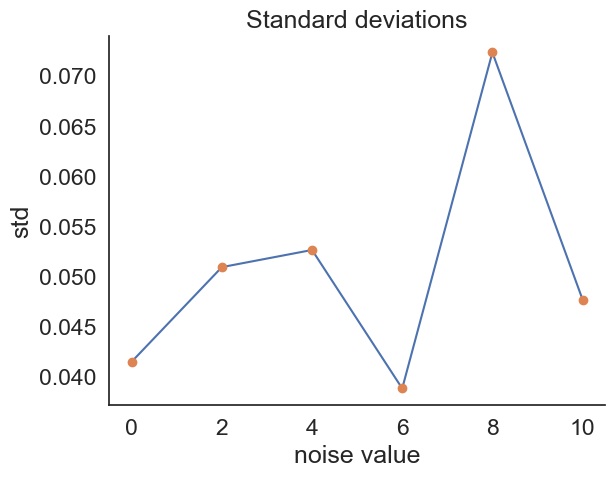

In [96]:
plt.plot(noise,std)
plt.plot(noise,std,'o')
plt.title('Standard deviations')
plt.xlabel('noise value')
plt.ylabel('std')

## Exercise 5
---
Explore the effect of the data duration and the firing rate on the goodness of fit of the Poisson GLM.

A - Generate data with durations of 10,20,50,100 and 200 seconds. Fit the model on each dataset and plot the fitted parameters.
Use the pearson correlation as a proxy of the goodness of fit, and plot it as a function of the duration of the data.

B - Fix the duration to 100s, and change the average firing rate of the simulation. How does the fit perform for different firing rates? 

In [30]:
#Looping over different durations
ddurations = [10,20,50,100,200]
PPC=[]
for j in ddurations:
    n_bins = round(j / float(dt))
    S = std_dev * np.random.randn(n_bins,vf_size[0],vf_size[1])
    S_flat = S.reshape(S.shape[0],S.shape[1]*S.shape[2])
    S_flat = np.hstack((S_flat, np.ones((n_bins, 1))))


    # 1. linear stage
    ks = np.dot(K_flat, S_flat.T)

    # 2. nonlinear stage (for a linear model: f -> identity function)
    lamda = np.exp(ks)

    expected_rate = np.sum(lamda*dt) / j
    lamda *= (spike_rate / expected_rate)

    # generate spike times using an inhomogeneous Poisson process
    spike_times = generate_inhomogeneous_poisson_spikes(lamda, dt)

    # compute spike counts in the different time bins
    spike_counts = np.histogram(spike_times,
                                bins=np.arange(n_bins+1)*dt)[0]
    k_STA = np.inner(S_flat.T, spike_counts) / np.sum(spike_counts)
    res = minimize(fun = cost, x0 = k_STA / 10, args = (spike_counts, S_flat), method = 'Newton-CG', jac = grad)

    K_est = res.x
    
    ppcorr=format(np.inner(K.ravel(), K_est[:-1]) / (np.linalg.norm(K.ravel()) * np.linalg.norm(K_est[:-1])))
    PPC.append(ppcorr)
    print(j, "seconds Pearson correlation = {:.3f}".format(np.inner(K.ravel(), K_est[:-1]) / (np.linalg.norm(K.ravel()) * np.linalg.norm(K_est[:-1]))))
TPPC = [eval(i) for i in PPC]

    

10 seconds Pearson correlation = 0.134
20 seconds Pearson correlation = 0.295
50 seconds Pearson correlation = 0.511
100 seconds Pearson correlation = 0.741
200 seconds Pearson correlation = 0.927


(0.0, 1.0)

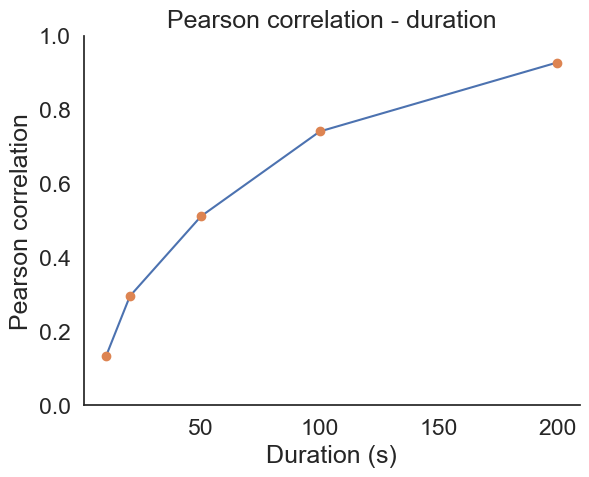

In [31]:
#1st Plot
plt.plot(ddurations,TPPC)
plt.plot(ddurations,TPPC,'o')
plt.xlabel('Duration (s)')
plt.ylabel('Pearson correlation')
plt.title('Pearson correlation - duration')
plt.ylim(0,1)

In [25]:
#Looping over different durations
dduration = 100
PPPC=[]
firate=[1,5,8,15,20]
for j in firate:
    n_bins = round(dduration / float(dt))
    S = std_dev * np.random.randn(n_bins,vf_size[0],vf_size[1])
    S_flat = S.reshape(S.shape[0],S.shape[1]*S.shape[2])
    S_flat = np.hstack((S_flat, np.ones((n_bins, 1))))


    # 1. linear stage
    ks = np.dot(K_flat, S_flat.T)

    # 2. nonlinear stage (for a linear model: f -> identity function)
    lamda = np.exp(ks)

    expected_rate = np.sum(lamda*dt) / dduration
    lamda *= (j / expected_rate)

    # generate spike times using an inhomogeneous Poisson process
    spike_times = generate_inhomogeneous_poisson_spikes(lamda, dt)

    # compute spike counts in the different time bins
    spike_counts = np.histogram(spike_times,
                                bins=np.arange(n_bins+1)*dt)[0]
    k_STA = np.inner(S_flat.T, spike_counts) / np.sum(spike_counts)
    res = minimize(fun = cost, x0 = k_STA / 10, args = (spike_counts, S_flat), method = 'Newton-CG', jac = grad)

    K_est = res.x
    
    pppcorr=format(np.inner(K.ravel(), K_est[:-1]) / (np.linalg.norm(K.ravel()) * np.linalg.norm(K_est[:-1])))
    PPPC.append(pppcorr)
    print(j, "firing rate Pearson correlation = {:.3f}".format(np.inner(K.ravel(), K_est[:-1]) / (np.linalg.norm(K.ravel()) * np.linalg.norm(K_est[:-1]))))
TPPPC = [eval(i) for i in PPPC]

    

1 firing rate Pearson correlation = 0.603
5 firing rate Pearson correlation = 0.771
8 firing rate Pearson correlation = 0.733
15 firing rate Pearson correlation = 0.909
20 firing rate Pearson correlation = 0.940


Text(0.5, 1.0, 'Firing rate - duration')

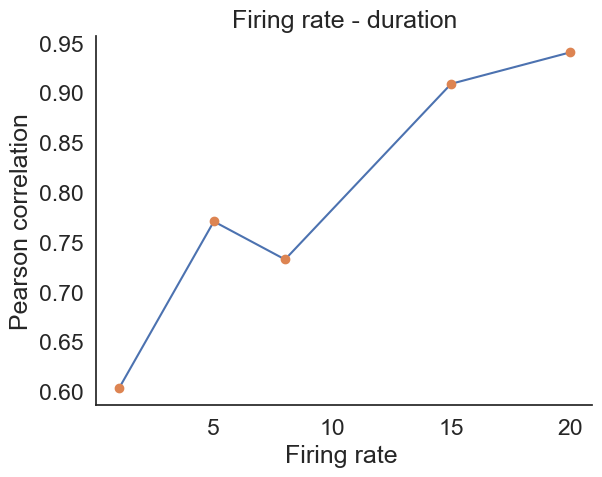

In [29]:
#2nd Plot
plt.plot(firate,TPPPC)
plt.plot(firate,TPPPC,'o')
plt.xlabel('Firing rate ')
plt.ylabel('Pearson correlation')
plt.title('Firing rate - duration')


 <font color='blue'>As is the case with duration, firing rate also has an analogous relation with Pearson correlation. As it increases, Pearson correlation increases as well.</font> 
